In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-16 21:20:11.480989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 21:20:14.761249: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-16 21:20:14.761448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

2.11.0


In [2]:
# !git clone https://github.com/EricMartinezIllamola/asl-alphabet.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "asl-alphabet/asl-alphabet"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.6, 0.2, 0.2))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
tf.config.experimental.list_physical_devices()

2023-09-16 21:20:19.010346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 21:20:19.024837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 21:20:19.027604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 64 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 44695 images belonging to 24 classes.
Found 14892 images belonging to 24 classes.
Found 14921 images belonging to 24 classes.


In [10]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-16 21:20:25.789584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 21:20:25.791358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 21:20:25.794808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 21:20:25.797537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
##DEFINIMOS EL MODELO
num_classes = 24
epochs = 50

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [12]:
## EJECUCION DEL MODELO
# with tf.device("/CPU:0"):
# with tf.device("/GPU:0"):
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

metric = 'val_accuracy'

checkpointer = ModelCheckpoint(filepath='model-04', verbose=1, save_best_only=True,
                               monitor = metric, mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, validation_data = valid_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/50


2023-09-16 21:20:31.861961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-09-16 21:20:34.397740: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f0f10949c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-16 21:20:34.397788: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-09-16 21:20:34.477899: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


699/699 [==============================] - ETA: 0s - loss: 7.8673 - accuracy: 0.1540
Epoch 1: val_accuracy improved from -inf to 0.41485, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 125s 169ms/step - loss: 7.8673 - accuracy: 0.1540 - val_loss: 6.9381 - val_accuracy: 0.4149 - lr: 0.0010
Epoch 2/50
699/699 [==============================] - ETA: 0s - loss: 6.4868 - accuracy: 0.5011
Epoch 2: val_accuracy improved from 0.41485 to 0.68090, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 118s 168ms/step - loss: 6.4868 - accuracy: 0.5011 - val_loss: 5.8951 - val_accuracy: 0.6809 - lr: 0.0010
Epoch 3/50
699/699 [==============================] - ETA: 0s - loss: 5.6779 - accuracy: 0.7085
Epoch 3: val_accuracy improved from 0.68090 to 0.76706, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 116s 165ms/step - loss: 5.6779 - accuracy: 0.7085 - val_loss: 5.4248 - val_accuracy: 0.7671 - lr: 0.0010
Epoch 4/50
699/699 [==============================] - ETA: 0s - loss: 5.2839 - accuracy: 0.7928
Epoch 4: val_accuracy improved from 0.76706 to 0.81863, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 116s 166ms/step - loss: 5.2839 - accuracy: 0.7928 - val_loss: 5.1329 - val_accuracy: 0.8186 - lr: 0.0010
Epoch 5/50
699/699 [==============================] - ETA: 0s - loss: 5.0240 - accuracy: 0.8328
Epoch 5: val_accuracy improved from 0.81863 to 0.86771, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 116s 166ms/step - loss: 5.0240 - accuracy: 0.8328 - val_loss: 4.8510 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 6/50
699/699 [==============================] - ETA: 0s - loss: 4.8162 - accuracy: 0.8591
Epoch 6: val_accuracy improved from 0.86771 to 0.88652, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 117s 167ms/step - loss: 4.8162 - accuracy: 0.8591 - val_loss: 4.6635 - val_accuracy: 0.8865 - lr: 0.0010
Epoch 7/50
699/699 [==============================] - ETA: 0s - loss: 4.6451 - accuracy: 0.8747
Epoch 7: val_accuracy improved from 0.88652 to 0.90304, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 116s 165ms/step - loss: 4.6451 - accuracy: 0.8747 - val_loss: 4.4996 - val_accuracy: 0.9030 - lr: 0.0010
Epoch 8/50
699/699 [==============================] - ETA: 0s - loss: 4.4879 - accuracy: 0.8886
Epoch 8: val_accuracy did not improve from 0.90304
699/699 [==============================] - 112s 160ms/step - loss: 4.4879 - accuracy: 0.8886 - val_loss: 4.3906 - val_accuracy: 0.8999 - lr: 0.0010
Epoch 9/50
699/699 [==============================] - ETA: 0s - loss: 4.3409 - accuracy: 0.8996
Epoch 9: val_accuracy improved from 0.90304 to 0.92325, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 117s 167ms/step - loss: 4.3409 - accuracy: 0.8996 - val_loss: 4.2156 - val_accuracy: 0.9232 - lr: 0.0010
Epoch 10/50
699/699 [==============================] - ETA: 0s - loss: 4.1982 - accuracy: 0.9108
Epoch 10: val_accuracy improved from 0.92325 to 0.92855, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 116s 166ms/step - loss: 4.1982 - accuracy: 0.9108 - val_loss: 4.0896 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 11/50
699/699 [==============================] - ETA: 0s - loss: 4.0733 - accuracy: 0.9161
Epoch 11: val_accuracy improved from 0.92855 to 0.93057, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 117s 167ms/step - loss: 4.0733 - accuracy: 0.9161 - val_loss: 3.9773 - val_accuracy: 0.9306 - lr: 0.0010
Epoch 12/50
699/699 [==============================] - ETA: 0s - loss: 3.9511 - accuracy: 0.9220
Epoch 12: val_accuracy improved from 0.93057 to 0.93453, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 117s 168ms/step - loss: 3.9511 - accuracy: 0.9220 - val_loss: 3.8650 - val_accuracy: 0.9345 - lr: 0.0010
Epoch 13/50
699/699 [==============================] - ETA: 0s - loss: 3.8356 - accuracy: 0.9268
Epoch 13: val_accuracy improved from 0.93453 to 0.93815, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 116s 166ms/step - loss: 3.8356 - accuracy: 0.9268 - val_loss: 3.7516 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 14/50
699/699 [==============================] - ETA: 0s - loss: 3.7225 - accuracy: 0.9296
Epoch 14: val_accuracy improved from 0.93815 to 0.94923, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 116s 166ms/step - loss: 3.7225 - accuracy: 0.9296 - val_loss: 3.6216 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 15/50
699/699 [==============================] - ETA: 0s - loss: 3.6085 - accuracy: 0.9348
Epoch 15: val_accuracy did not improve from 0.94923
699/699 [==============================] - 111s 159ms/step - loss: 3.6085 - accuracy: 0.9348 - val_loss: 3.5322 - val_accuracy: 0.9468 - lr: 0.0010
Epoch 16/50
699/699 [==============================] - ETA: 0s - loss: 3.5104 - accuracy: 0.9378
Epoch 16: val_accuracy did not improve from 0.94923
699/699 [==============================] - 112s 160ms/step - loss: 3.5104 - accuracy: 0.9378 - val_loss: 3.4383 - val_accuracy: 0.9472 - lr: 0.0010
Epoch 17/50
699/699 [==============================] - ETA: 0s - loss: 3.4085 - accuracy: 0.9399
Epoch 17: val_accuracy improved from 0.94923 to 0.95071, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 115s 165ms/step - loss: 3.4085 - accuracy: 0.9399 - val_loss: 3.3370 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 18/50
699/699 [==============================] - ETA: 0s - loss: 3.3128 - accuracy: 0.9446
Epoch 18: val_accuracy improved from 0.95071 to 0.95696, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 116s 166ms/step - loss: 3.3128 - accuracy: 0.9446 - val_loss: 3.2325 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 19/50
699/699 [==============================] - ETA: 0s - loss: 3.2192 - accuracy: 0.9462
Epoch 19: val_accuracy improved from 0.95696 to 0.96213, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 116s 165ms/step - loss: 3.2192 - accuracy: 0.9462 - val_loss: 3.1376 - val_accuracy: 0.9621 - lr: 0.0010
Epoch 20/50
699/699 [==============================] - ETA: 0s - loss: 3.1280 - accuracy: 0.9488
Epoch 20: val_accuracy did not improve from 0.96213
699/699 [==============================] - 111s 159ms/step - loss: 3.1280 - accuracy: 0.9488 - val_loss: 3.0757 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 21/50
699/699 [==============================] - ETA: 0s - loss: 3.0393 - accuracy: 0.9515
Epoch 21: val_accuracy did not improve from 0.96213
699/699 [==============================] - 110s 157ms/step - loss: 3.0393 - accuracy: 0.9515 - val_loss: 2.9752 - val_accuracy: 0.9595 - lr: 0.0010
Epoch 22/50
699/699 [==============================] - ETA: 0s - loss: 2.9551 - accuracy: 0.9524
Epoch 22: val_accuracy did not improve from 0.96213
699/699 [==============================] - 111s 158ms/step - loss: 2.9551 - accuracy: 0.9524 - val_loss: 2.89

INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 115s 164ms/step - loss: 2.8718 - accuracy: 0.9543 - val_loss: 2.8120 - val_accuracy: 0.9622 - lr: 0.0010
Epoch 24/50
699/699 [==============================] - ETA: 0s - loss: 2.7946 - accuracy: 0.9552
Epoch 24: val_accuracy improved from 0.96219 to 0.96595, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 114s 164ms/step - loss: 2.7946 - accuracy: 0.9552 - val_loss: 2.7270 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 25/50
699/699 [==============================] - ETA: 0s - loss: 2.7140 - accuracy: 0.9588
Epoch 25: val_accuracy did not improve from 0.96595
699/699 [==============================] - 112s 159ms/step - loss: 2.7140 - accuracy: 0.9588 - val_loss: 2.6664 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 26/50
699/699 [==============================] - ETA: 0s - loss: 2.6378 - accuracy: 0.9603
Epoch 26: val_accuracy improved from 0.96595 to 0.96642, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 116s 166ms/step - loss: 2.6378 - accuracy: 0.9603 - val_loss: 2.5835 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 27/50
699/699 [==============================] - ETA: 0s - loss: 2.5673 - accuracy: 0.9597
Epoch 27: val_accuracy did not improve from 0.96642
699/699 [==============================] - 112s 160ms/step - loss: 2.5673 - accuracy: 0.9597 - val_loss: 2.5187 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 28/50
699/699 [==============================] - ETA: 0s - loss: 2.4998 - accuracy: 0.9599
Epoch 28: val_accuracy did not improve from 0.96642
699/699 [==============================] - 112s 160ms/step - loss: 2.4998 - accuracy: 0.9599 - val_loss: 2.4534 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 29/50
699/699 [==============================] - ETA: 0s - loss: 2.4245 - accuracy: 0.9632
Epoch 29: val_accuracy improved from 0.96642 to 0.96925, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 117s 167ms/step - loss: 2.4245 - accuracy: 0.9632 - val_loss: 2.3784 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 30/50
699/699 [==============================] - ETA: 0s - loss: 2.3595 - accuracy: 0.9641
Epoch 30: val_accuracy did not improve from 0.96925
699/699 [==============================] - 111s 158ms/step - loss: 2.3595 - accuracy: 0.9641 - val_loss: 2.3203 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 31/50
699/699 [==============================] - ETA: 0s - loss: 2.2932 - accuracy: 0.9653
Epoch 31: val_accuracy did not improve from 0.96925
699/699 [==============================] - 110s 157ms/step - loss: 2.2932 - accuracy: 0.9653 - val_loss: 2.2534 - val_accuracy: 0.9682 - lr: 0.0010
Epoch 32/50
699/699 [==============================] - ETA: 0s - loss: 2.2353 - accuracy: 0.9639
Epoch 32: val_accuracy did not improve from 0.96925
699/699 [==============================] - 109s 156ms/step - loss: 2.2353 - accuracy: 0.9639 - val_loss: 2.19

INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 116s 166ms/step - loss: 2.1745 - accuracy: 0.9663 - val_loss: 2.1300 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 34/50
699/699 [==============================] - ETA: 0s - loss: 2.1169 - accuracy: 0.9656
Epoch 34: val_accuracy did not improve from 0.97133
699/699 [==============================] - 113s 161ms/step - loss: 2.1169 - accuracy: 0.9656 - val_loss: 2.0742 - val_accuracy: 0.9711 - lr: 0.0010
Epoch 35/50
699/699 [==============================] - ETA: 0s - loss: 2.0582 - accuracy: 0.9672
Epoch 35: val_accuracy did not improve from 0.97133
699/699 [==============================] - 111s 159ms/step - loss: 2.0582 - accuracy: 0.9672 - val_loss: 2.0286 - val_accuracy: 0.9679 - lr: 0.0010
Epoch 36/50
699/699 [==============================] - ETA: 0s - loss: 2.0003 - accuracy: 0.9687
Epoch 36: val_accuracy did not improve from 0.97133
699/699 [==============================] - 111s 159ms/step - loss: 2.0003 - accuracy: 0.9687 - val_loss: 1.96

INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 116s 166ms/step - loss: 1.9534 - accuracy: 0.9682 - val_loss: 1.9048 - val_accuracy: 0.9754 - lr: 0.0010
Epoch 38/50
699/699 [==============================] - ETA: 0s - loss: 1.8945 - accuracy: 0.9694
Epoch 38: val_accuracy did not improve from 0.97542
699/699 [==============================] - 109s 156ms/step - loss: 1.8945 - accuracy: 0.9694 - val_loss: 1.8583 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 39/50
699/699 [==============================] - ETA: 0s - loss: 1.8424 - accuracy: 0.9703
Epoch 39: val_accuracy did not improve from 0.97542
699/699 [==============================] - 109s 156ms/step - loss: 1.8424 - accuracy: 0.9703 - val_loss: 1.8104 - val_accuracy: 0.9741 - lr: 0.0010
Epoch 40/50
699/699 [==============================] - ETA: 0s - loss: 1.7947 - accuracy: 0.9702
Epoch 40: val_accuracy improved from 0.97542 to 0.97979, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


699/699 [==============================] - 114s 163ms/step - loss: 1.7947 - accuracy: 0.9702 - val_loss: 1.7504 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 41/50
699/699 [==============================] - ETA: 0s - loss: 1.7448 - accuracy: 0.9703
Epoch 41: val_accuracy did not improve from 0.97979
699/699 [==============================] - 109s 156ms/step - loss: 1.7448 - accuracy: 0.9703 - val_loss: 1.7198 - val_accuracy: 0.9718 - lr: 0.0010
Epoch 42/50
699/699 [==============================] - ETA: 0s - loss: 1.7004 - accuracy: 0.9715
Epoch 42: val_accuracy did not improve from 0.97979
699/699 [==============================] - 108s 155ms/step - loss: 1.7004 - accuracy: 0.9715 - val_loss: 1.6650 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 43/50
699/699 [==============================] - ETA: 0s - loss: 1.6513 - accuracy: 0.9726
Epoch 43: val_accuracy did not improve from 0.97979
699/699 [==============================] - 110s 157ms/step - loss: 1.6513 - accuracy: 0.9726 - val_loss: 1.61

In [13]:
preds_test = model.predict(test_generator)

234/234 [==============================] - 28s 119ms/step


In [14]:
evaluate_test = model.evaluate(test_generator)

234/234 [==============================] - 27s 117ms/step - loss: 1.3474 - accuracy: 0.9756


In [15]:
evaluate_test

[1.347383975982666, 0.9756048321723938]

In [16]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([ 2,  0, 16, ..., 23, 23, 23])

In [17]:
y_real_test = test_generator.classes
y_real_test

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [18]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.9767441860465116

In [19]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[602,   3,   1,   0,   6,   0,   0,   0,   0,   1,   0,   2,   0,
          0,   0,   0,   1,   1,   3,   0,   0,   0,   0,   0],
       [  1, 617,   0,   1,   1,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0],
       [  1,   1, 630,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,   0, 613,   0,   1,   0,   0,   2,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   0,   2,   1,   0,   0,   0],
       [  0,   3,   4,   0, 621,   0,   0,   0,   2,   0,   0,   1,   0,
          0,   0,   0,   0,   4,   1,   1,   0,   0,   0,   0],
       [  0,   0,   1,   0,   1, 611,   2,   0,   2,   1,   0,   1,   0,
          0,   1,   0,   1,   0,   0,   0,   0,   1,   0,   2],
       [  0,   0,   0,   0,   1,   0, 603,  11,   1,   0,   1,   0,   0,
          0,   3,   0,   0,   1,   0,   2,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1

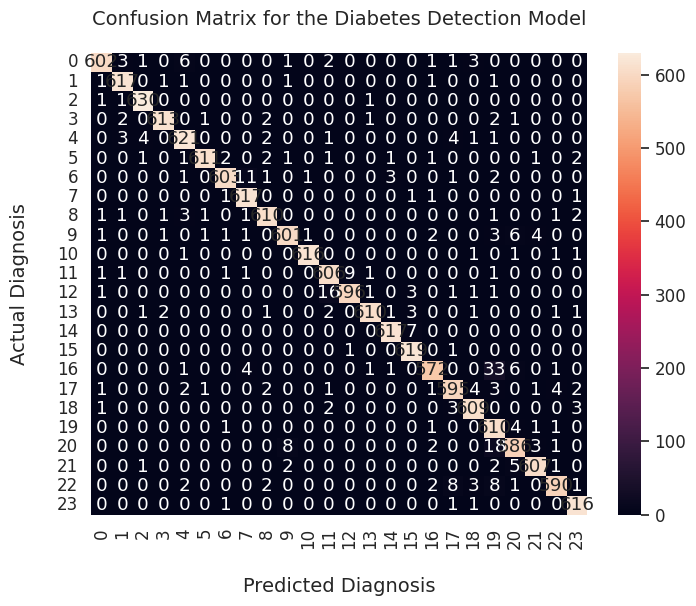

In [20]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [21]:
preds_val = model.predict(valid_generator)

233/233 [==============================] - 27s 116ms/step


In [22]:
evaluate_val = model.evaluate(valid_generator)

233/233 [==============================] - 27s 115ms/step - loss: 1.3426 - accuracy: 0.9772


In [23]:
evaluate_val

[1.3425661325454712, 0.9771689772605896]

In [24]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([ 2,  1,  0, ..., 23, 23, 23])

In [25]:
y_real_val = valid_generator.classes
y_real_val

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [26]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9786462530217567

In [27]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[601,   3,   3,   0,   5,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   1,   2,   1,   0,   0,   1,   0],
       [  0, 617,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   1],
       [  0,   0, 622,   1,   4,   0,   0,   0,   1,   0,   0,   1,   0,
          2,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   1,   1, 611,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          3,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0],
       [  1,   4,   0,   1, 618,   0,   0,   0,   6,   0,   1,   0,   0,
          1,   0,   0,   2,   1,   2,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 611,   0,   1,   1,   3,   0,   0,   0,
          0,   0,   0,   3,   0,   0,   0,   1,   2,   0,   0],
       [  0,   1,   0,   0,   0,   0, 610,   8,   1,   0,   0,   0,   0,
          0,   2,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   3

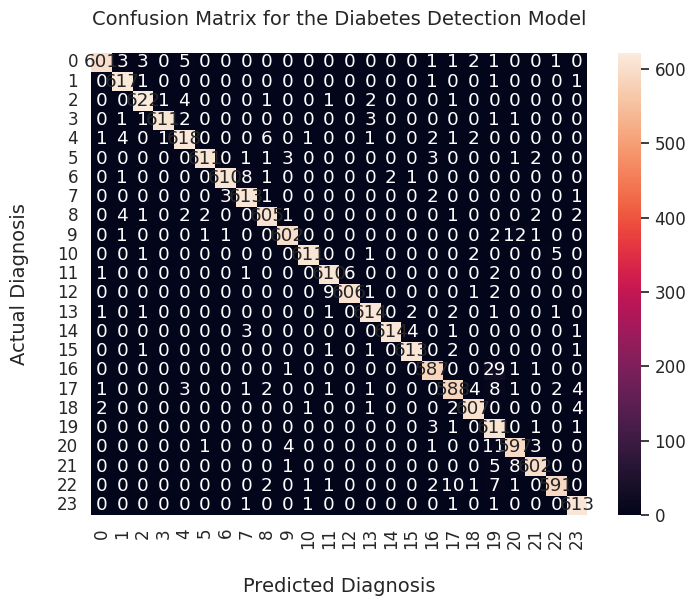

In [28]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()